In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
talking = pd.read_csv('data/model_selection2m.csv', parse_dates = ['click_time'])

In [3]:
len(talking)

2000000

In [4]:
# transform click_time into day, hour, minute and second
talking['day'] = talking['click_time'].dt.day
talking['hour'] = talking['click_time'].dt.hour
talking['minute'] = talking['click_time'].dt.minute
talking['second'] = talking['click_time'].dt.second
talking.head()

,Unnamed: 0,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second
0,31655873,197955,9,1,13,258,2017-11-07 06:45:50,NaN,0,7,6,45,50
1,105493957,5314,2,1,27,477,2017-11-08 11:17:28,NaN,0,8,11,17,28
2,146879719,48782,18,1,13,107,2017-11-09 04:33:03,NaN,0,9,4,33,3
3,173149719,83230,3,1,13,115,2017-11-09 12:27:31,NaN,0,9,12,27,31
4,20397653,100896,9,1,27,445,2017-11-07 03:20:18,NaN,0,7,3,20,18


In [5]:
heads = talking.columns
print(heads)
for i in list(range(0,5)) + list(range(-1, -6, -1)):
    talking[heads[i]] = talking[heads[i]].astype('category')
talking.info()

Index(['Unnamed: 0', 'ip', 'app', 'device', 'os', 'channel', 'click_time',
       'attributed_time', 'is_attributed', 'day', 'hour', 'minute', 'second'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 13 columns):
Unnamed: 0         category
ip                 category
app                category
device             category
os                 category
channel            int64
click_time         datetime64[ns]
attributed_time    object
is_attributed      category
day                category
hour               category
minute             category
second             category
dtypes: category(10), datetime64[ns](1), int64(1), object(1)
memory usage: 180.6+ MB


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve
from sklearn import datasets, neighbors, linear_model

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt


In [7]:
len(talking[talking['is_attributed']==1])

4888

In [8]:
talking = talking.drop(['attributed_time','Unnamed: 0','click_time'],axis=1)

In [9]:
len(talking)

2000000

In [10]:
# down sample the train set
df_majority = talking[talking['is_attributed']==0]
df_minority = talking[talking['is_attributed']==1]

df_majority_downsampled = df_majority.sample(replace=False,    # sample without replacement
                                frac=len(df_minority)/len(df_majority),     
                                random_state=42) # reproducible results

balanced_train = pd.concat([df_majority_downsampled, df_minority])
# balanced_train = balanced_train.sample(frac=1)

# balanced_train = balanced_train.drop(columns=['click_time','attributed_time'])
balanced_train['is_attributed'] = balanced_train['is_attributed'].astype('int64')

In [11]:
talking[talking['is_attributed']==1]
len(df_minority)

4888

In [12]:
y = balanced_train['is_attributed']
X = balanced_train.drop(['is_attributed'], axis=1)
X.shape

(9776, 9)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
pip_knn = Pipeline([('clf', KNeighborsClassifier())])
pip_rfc = Pipeline([('clf', RandomForestClassifier(n_estimators=100))])
pip_lr = Pipeline([('clf', LogisticRegression(solver='lbfgs'))])
pip_gnb = Pipeline([('clf', GaussianNB())])
pip_gbc = Pipeline([('clf', GradientBoostingClassifier())])
pip_mlp = Pipeline([('clf', MLPClassifier())])
pip_svc1 = Pipeline([('clf', LinearSVC())])
pip_svc2 = Pipeline([('clf', SVC())])
pip_xgb = Pipeline([('clf', XGBClassifier())])
# pip_lgb = Pipeline([('clf', LGBMClassifier())])

# pipelines = [pip_knn, pip_rfc, pip_lr, pip_gnb, pip_gbc, pip_mlp, pip_svc1, pip_svc2, pip_xgb, pip_lgb]
pipelines = [pip_knn, pip_rfc, pip_lr, pip_gnb, pip_gbc, pip_mlp, pip_svc1, pip_svc2, pip_xgb]

In [16]:
warnings.filterwarnings('ignore')

plot_df = pd.DataFrame(columns=['type','roc_auc','f1_score'])
for i in range(0,100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i*2)
    for pipe in pipelines:
        pipe.fit(X_train.values, y_train)
        name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
        a = roc_auc_score(y_test, pipe.predict(X_test.values))
        b = f1_score(y_test,pipe.predict(X_test.values))
        plot_df = plot_df.append({'type':name,'roc_auc':a, 'f1_score':b}, ignore_index=True)

In [21]:
plot_df.sort_values(['roc_auc', 'f1_score'], ascending=[False, False]).head(10)

,type,roc_auc,f1_score
532,RandomForestClassifier,0.925104,0.921674
892,RandomForestClassifier,0.921566,0.916574
539,XGBClassifier,0.921459,0.916983
292,GradientBoostingClassifier,0.920768,0.916395
535,GradientBoostingClassifier,0.920475,0.916442
845,XGBClassifier,0.920102,0.916261
289,RandomForestClassifier,0.919767,0.915493
352,RandomForestClassifier,0.919715,0.915858
445,GradientBoostingClassifier,0.919323,0.915236
667,RandomForestClassifier,0.919143,0.914474


In [20]:
file_name='./data/pipeline_roc_vs_f1.csv'
plot_df.to_csv(file_name, sep=',', encoding='utf-8')

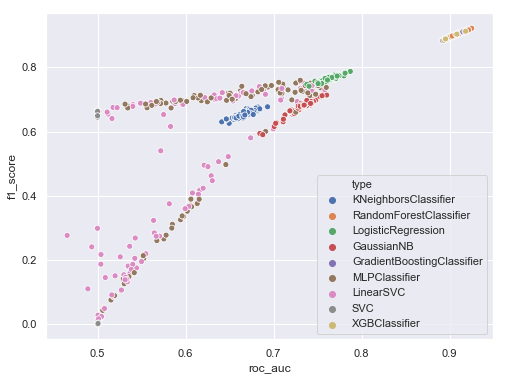

In [25]:
sns.set(rc={'figure.figsize':(8,6)})
ax = sns.scatterplot(x="roc_auc", y="f1_score", hue="type", data=plot_df)

so top 3 are xgb, rfc and gbc